In [2]:
pip install torch torchvision lightgbm scikit-learn matplotlib seaborn pandas tqdm pillow

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 23.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   - -------------------------------------- 6.0/216.1 MB 28.3 MB/s eta 0:00:08
   - -------------------------------------- 9.7/216.1 MB 23.2 MB/s eta 0:00:09
   -- ------------------------------------- 13.6/216.1 MB 21.9 MB/s eta 0:00:10
   --- ------------------------------------ 17.8/216.1 MB 21.2 MB/s eta 0:00:10
   ---- ----------------------------------- 22.0/216.1 MB 20.8 MB/s eta 0:00:10
   ---- ----------------------------------- 25.7/216.1 MB 20.6 MB/s eta 0:00:10
   ----- ---------------------------------- 29.9/216.1 MB 20.4 MB/s eta 0:00:10
   ------ --------------------------------- 34.1/216.1 MB 20.2 MB/s eta 0:00:09
   ------- -------------------------------- 38.0/216.1 MB 20.1 MB/s eta 0:00:09
   ------- -------------------------------- 41.9/216.1 MB 20.0 MB

C:\Users\hasan\AppData\Local\Temp\ipykernel_1424\3603744488.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = mpl_cm.get_cmap('jet')


Loading datasets...
Number of training samples: 4192
Number of test samples: 624

Extracting training features...


100%|██████████| 131/131 [02:33<00:00,  1.17s/it]



Extracting test features...


100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Train features shape: (4192, 512)
Test features shape: (624, 512)

Training LightGBM on full training set...
Fold 1: Acc=0.9571, F1=0.9708, AUC=0.9878
Fold 2: Acc=0.9416, F1=0.9606, AUC=0.9872
Fold 3: Acc=0.9415, F1=0.9605, AUC=0.9878
Fold 4: Acc=0.9594, F1=0.9724, AUC=0.9884
Fold 5: Acc=0.9439, F1=0.9621, AUC=0.9835

Overall OOF Metrics: Acc=0.9487, F1=0.9653, AUC=0.9870

Test Metrics: Acc=0.8558, F1=0.8889, AUC=0.9346


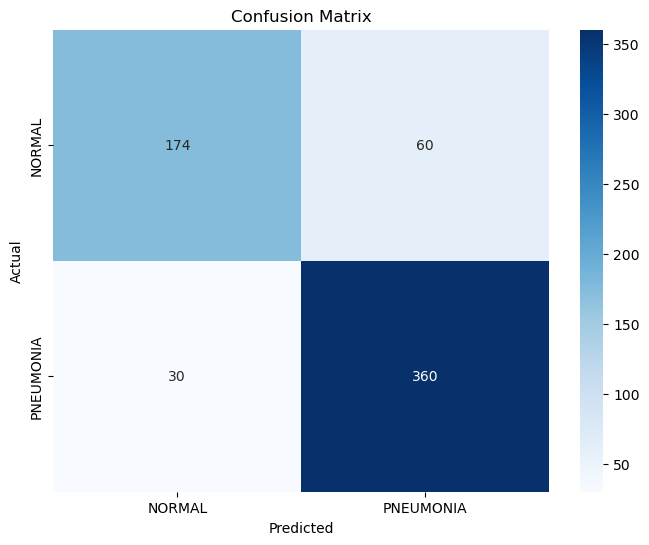

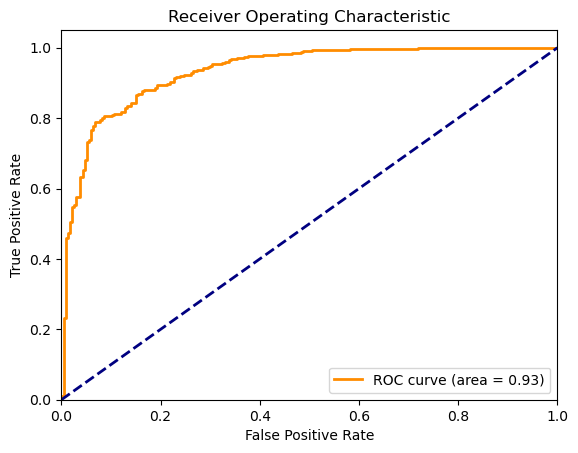


Generating Grad-CAM visualizations...


C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_bac

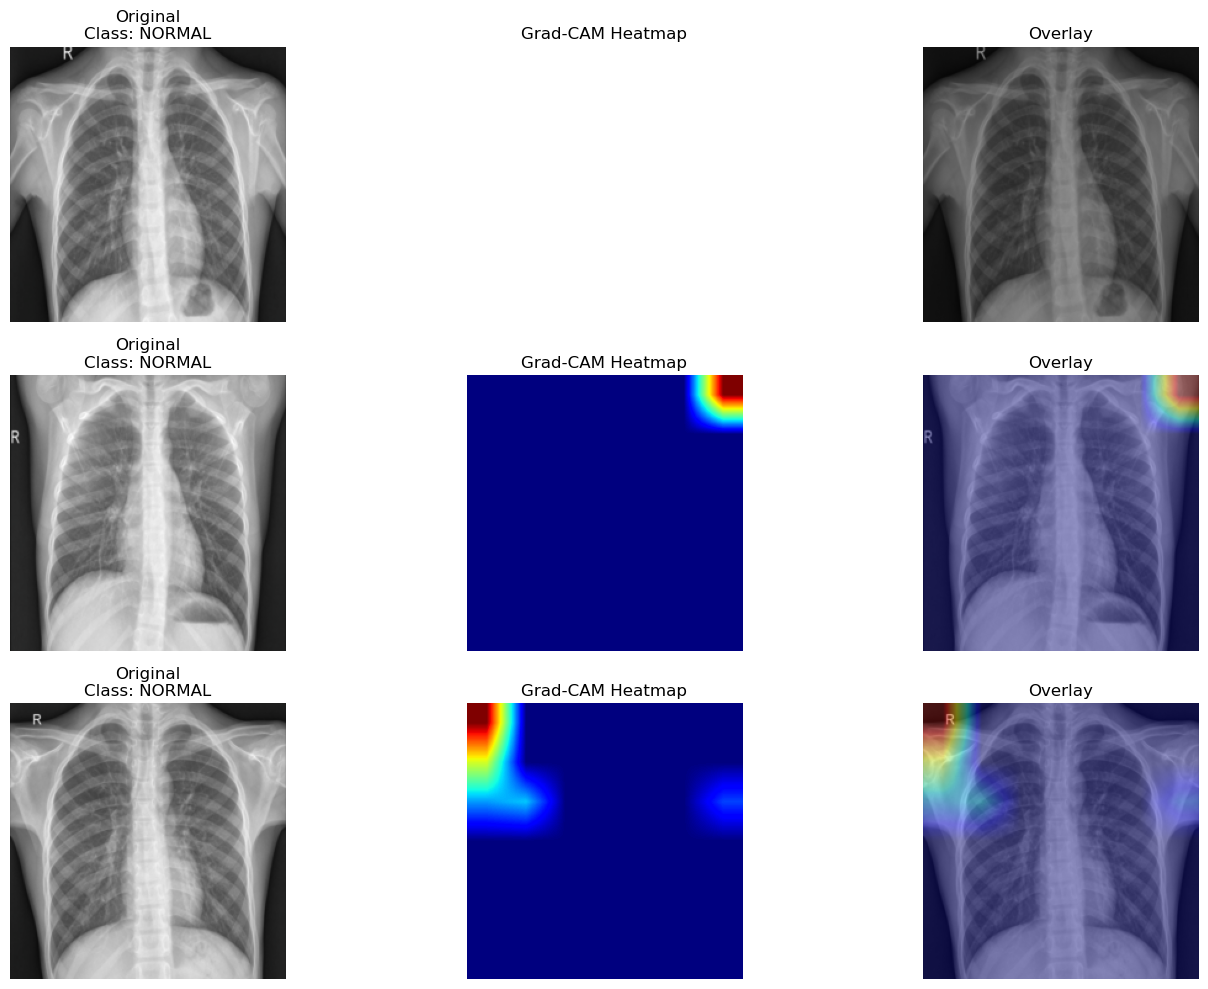

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, f1_score, 
                            roc_auc_score, confusion_matrix, 
                            roc_curve, auc)
# Add this at the very top with other imports
import matplotlib  # Add this line

# Rest of imports remain the same
import os
import numpy as np
# ... [other imports] ...
from matplotlib import cm
import lightgbm as lgb
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F
from matplotlib import cm
import matplotlib.cm as mpl_cm
jet = mpl_cm.get_cmap('jet')
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----------------------------
# 1. Data Preparation
# ----------------------------
class ChestXRayDataset(Dataset):
    def __init__(self, data_dir, transform=None, mode='train'):
        self.data_dir = data_dir
        self.transform = transform
        self.mode = mode
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.image_paths = []
        self.labels = []
        
        # Load image paths and labels
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(data_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"Warning: Directory {class_dir} does not exist")
                continue
                
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(class_idx)
                
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            print(f"Error loading image: {img_path}")
            return None, None
            
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Data transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ----------------------------
# 2. Feature Extraction with CNN
# ----------------------------
def create_model(model_name='resnet18'):
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Identity()
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Identity()
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=True)
        num_ftrs = model.classifier[1].in_features
        model.classifier = nn.Identity()
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    return model.to(device), num_ftrs

def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            # Skip None values
            if inputs is None or targets is None:
                continue
                
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
            
    return np.vstack(features) if features else np.array([]), np.concatenate(labels) if labels else np.array([])

# ----------------------------
# 3. LightGBM Classifier
# ----------------------------
def train_lightgbm(X, y, test_features=None, n_folds=5):
    if len(X) == 0 or len(y) == 0:
        print("Error: No data provided to train_lightgbm")
        return [], np.array([]), None
        
    models = []
    oof_preds = np.zeros(len(y))
    test_preds = np.zeros(test_features.shape[0]) if test_features is not None else None
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Handle class imbalance
        class_counts = np.bincount(y_train)
        if len(class_counts) < 2:
            print(f"Warning: Only one class present in fold {fold+1}")
            continue
            
        class_weights = {0: len(y_train) / (2 * class_counts[0]),
                         1: len(y_train) / (2 * class_counts[1])}
        
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)
        
        params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'metric': 'binary_logloss',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'seed': 42,
            'scale_pos_weight': class_weights[1] / class_weights[0]
        }
        
        model = lgb.train(
            params,
            train_data,
            valid_sets=[val_data],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
            ]
        )
        
        val_pred = model.predict(X_val, num_iteration=model.best_iteration)
        oof_preds[val_idx] = val_pred
        
        if test_features is not None:
            test_preds += model.predict(test_features, num_iteration=model.best_iteration) / n_folds
        
        models.append(model)
        
        # Calculate fold metrics
        if len(np.unique(y_val)) > 1:  # Only calculate if both classes present
            val_pred_binary = (val_pred > 0.5).astype(int)
            fold_acc = accuracy_score(y_val, val_pred_binary)
            fold_f1 = f1_score(y_val, val_pred_binary)
            fold_auc = roc_auc_score(y_val, val_pred)
            print(f"Fold {fold+1}: Acc={fold_acc:.4f}, F1={fold_f1:.4f}, AUC={fold_auc:.4f}")
        else:
            print(f"Fold {fold+1}: Only one class present, skipping metrics")
    
    # Overall metrics
    if len(np.unique(y)) > 1:  # Only calculate if both classes present
        oof_preds_binary = (oof_preds > 0.5).astype(int)
        oof_acc = accuracy_score(y, oof_preds_binary)
        oof_f1 = f1_score(y, oof_preds_binary)
        oof_auc = roc_auc_score(y, oof_preds)
        print(f"\nOverall OOF Metrics: Acc={oof_acc:.4f}, F1={oof_f1:.4f}, AUC={oof_auc:.4f}")
    
    return models, oof_preds, test_preds

# ----------------------------
# 4. Grad-CAM Implementation
# ----------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Hook into target layer
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)
    
    def save_activations(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def __call__(self, x, class_idx=None):
        self.model.eval()
        
        # Forward pass
        output = self.model(x)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        
        # Backward pass
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot)
        
        # Calculate weights
        pooled_gradients = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        heatmap = torch.sum(self.activations * pooled_gradients, dim=1, keepdim=True)
        heatmap = torch.relu(heatmap)
        
        # Resize heatmap to match input size
        heatmap = F.interpolate(heatmap, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)
        heatmap = heatmap.squeeze().cpu().numpy()
        
        # Normalize
        heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
        return heatmap

# ----------------------------
# 5. Main Workflow
# ----------------------------
def main():
    # Configuration
    DATA_DIR = "D:\\chest_xray"
    TRAIN_DIR = os.path.join(DATA_DIR, "train")
    TEST_DIR = os.path.join(DATA_DIR, "test")
    MODEL_NAME = "resnet18"  # Change to densenet121 or efficientnet_b0
    BATCH_SIZE = 32
    
    # Load datasets
    print("Loading datasets...")
    train_dataset = ChestXRayDataset(TRAIN_DIR, transform=train_transform, mode='train')
    test_dataset = ChestXRayDataset(TEST_DIR, transform=test_transform, mode='test')
    
    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of test samples: {len(test_dataset)}")
    
    if len(train_dataset) == 0 or len(test_dataset) == 0:
        print("Error: No data loaded. Check your dataset paths.")
        return
        
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Create model and feature extractor
    model, num_ftrs = create_model(MODEL_NAME)
    
    # Extract features
    print("\nExtracting training features...")
    train_features, train_labels = extract_features(model, train_loader)
    print("\nExtracting test features...")
    test_features, test_labels = extract_features(model, test_loader)
    
    # Ensure we have data
    if len(train_features) == 0 or len(test_features) == 0:
        print("Error: Feature extraction failed")
        return
        
    print(f"Train features shape: {train_features.shape}")
    print(f"Test features shape: {test_features.shape}")
    
    # Train LightGBM on entire training set
    print("\nTraining LightGBM on full training set...")
    lgb_models, oof_preds, test_preds = train_lightgbm(
        train_features, train_labels, test_features=test_features, n_folds=5
    )
    
    if len(lgb_models) == 0:
        print("Error: No LightGBM models trained")
        return
        
    # Evaluate on test set
    test_preds_binary = (test_preds > 0.5).astype(int)
    
    if len(np.unique(test_labels)) > 1:
        test_acc = accuracy_score(test_labels, test_preds_binary)
        test_f1 = f1_score(test_labels, test_preds_binary)
        test_auc = roc_auc_score(test_labels, test_preds)
        print(f"\nTest Metrics: Acc={test_acc:.4f}, F1={test_f1:.4f}, AUC={test_auc:.4f}")
    else:
        print("\nWarning: Only one class in test set, skipping metrics")
    
    # ----------------------------
    # 6. Visualization and Interpretation
    # ----------------------------
    # Confusion Matrix
    if len(np.unique(test_labels)) > 1:
        conf_mat = confusion_matrix(test_labels, test_preds_binary)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['NORMAL', 'PNEUMONIA'], 
                    yticklabels=['NORMAL', 'PNEUMONIA'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.savefig('confusion_matrix.png')
        plt.show()
    else:
        print("Skipping confusion matrix - only one class present")
    
    # ROC Curve
    if len(np.unique(test_labels)) > 1:
        fpr, tpr, _ = roc_curve(test_labels, test_preds)
        roc_auc = auc(fpr, tpr)
        
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig('roc_curve.png')
        plt.show()
    else:
        print("Skipping ROC curve - only one class present")
    
    # Grad-CAM Visualization
    print("\nGenerating Grad-CAM visualizations...")
    # Recreate model with classification head for Grad-CAM
    cnn_model, _ = create_model(MODEL_NAME)
    cnn_model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 1),
        nn.Sigmoid()
    ).to(device)
    
    # Select target layer
    if MODEL_NAME == 'resnet18':
        target_layer = cnn_model.layer4[-1]
    elif MODEL_NAME == 'densenet121':
        target_layer = cnn_model.features.norm5
    elif MODEL_NAME == 'efficientnet_b0':
        target_layer = cnn_model.features[8][0]
    
    grad_cam = GradCAM(model=cnn_model, target_layer=target_layer)
    
    # Select sample images
    sample_indices = list(range(min(3, len(test_dataset))))
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(sample_indices):
        image, label = test_dataset[idx]
        if image is None:
            continue
            
        input_tensor = image.unsqueeze(0).to(device)
        
        # Get Grad-CAM heatmap
        try:
            heatmap = grad_cam(input_tensor)
        except Exception as e:
            print(f"Error generating Grad-CAM: {e}")
            continue
        
        # Process original image
        img = image.permute(1, 2, 0).cpu().numpy()
        img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
        img = np.clip(img, 0, 1)
        
        jet = matplotlib.cm.get_cmap('jet') 
        heatmap_rgb = jet(heatmap)[..., :3]
        
        # Overlay heatmap
        superimposed_img = heatmap_rgb * 0.4 + img * 0.6
        superimposed_img = np.clip(superimposed_img, 0, 1)
        
        # Plot
        plt.subplot(3, 3, i*3+1)
        plt.imshow(img)
        plt.title(f'Original\nClass: {"PNEUMONIA" if label else "NORMAL"}')
        plt.axis('off')
        
        plt.subplot(3, 3, i*3+2)
        plt.imshow(heatmap, cmap='jet')
        plt.title('Grad-CAM Heatmap')
        plt.axis('off')
        
        plt.subplot(3, 3, i*3+3)
        plt.imshow(superimposed_img)
        plt.title('Overlay')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('grad_cam.png')
    plt.show()

if __name__ == "__main__":
    main()